## Filtros Resposta Infinita ao Impulso

Vamos denominar Infinite Response Impulse Reponse (IIR) os filtros que são caracterizados pelas equações:
$$ y(n) = \sum_{k=0}^{N-1}b_k x(n-k) - \sum\limits_{k=1}^M a_k y(n-k)$$
$$ H(z) = \frac{\sum_{k=0}^{N-1}b_kz^{-k}}{1 + \sum\limits_{k=1}^{M}a_kz^{-k}}$$
sendo $b_k$ e $a_k$ os coeficientes que definem o filtro. 

Características:
1. A saída atual depende das entradas atual e anteriores, e das saída anteriores;
2. Filtros IIR nem sempre são estáveis;
3. Não há garantia de fase linear;

Dadas as especificações do filtro (tipo, tolerâncias nas bandas de passagem e rejeição), deve-se utilizar um método para determinar os coeficientes. Alguns desses métodos serão explorados a seguir.

### <font color='blue'> Método do cálculo pelo posicionamento de pólos e zeros </color>

O posicionamento dos pólos e zeros no plano $z$ modificam a resposta em frequência do sistema, por exemplo, um zero em determinada localização produzirá um zero na frequência correspondente, e um pólo um pico. A posição em relação ao círculo unitário também influencia na resposta. Na figura abaixo estes fatos estão representados.

![title](img/Fig83Ifeachor.png)


Deve-se levar em conta que para que os coeficiente do filtros sejam número reais (isso facilita a implementação), os pólos e zero devem ser reais ou ocorrerem em pares conjugados complexos.

Vamos considerar um filtro passa-faixas com as seguintes especificações:

1. Rejeição em DC e 250 Hz;
2. Faixa de passagem centrada em 125 Hz;
3. Uma largura de banda de 3dB de 10 Hz;
4. Frequência de amostragem de 500 Hz.

Primeiro precisamos determinar onde colocar os pólos e os zeros:

1. Rejeição em DC colocaremos um zero em $0^o$, para 250 Hz em $360^o \times 250/500 = 180^o$, ambas sobre o círculo unitário.
2. Para a banda de passagem faremos $\pm 360^{o} \times 125/500 = \pm 90^{o}$, que devem ser complexos conjugados. O raio $r$ onde os pólos serão colocados depende da banda de passagem desejada, e pode ser aproximado por $$r \approx 1 - (BW/Fs)\pi,$$ e para o problema chega-se a $r = 0,937$.

Por inspeção podemos escrever
$$ H(z) = \frac{(z-1)(z+1)}{(z - re^{j\pi/2})(z - re^{-j\pi/2})} = \frac{z^2 -1}{z^2 + 0,877969} = \frac{1 - z^{-2}}{1 + 0,877969z^{-2}}.$$

Que pode ser implementada em uma estrutura como está representada na Figura abaixo.

![title](img/fig84Ifeachor.png)

Alguns software necessitam quem sejam informados os coefcientes do filtro no formato $b_k$ e $a_k$. Inspecionando a função de transferência $H(z)$ chegamos a:
1. $b_0 = 1$, $b_1 = 0$, $b_2 = -1$;
2. $a_1 = 0$, $a_2 = 0,877969$.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


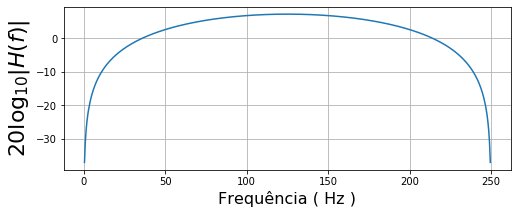

In [10]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
import scipy as scp

fs = 500

b = [1, 0, -1]
a = [0, 0.877696]


w,H = signal.freqz(b,a) # resposta em frequência

fig,ax = plt.subplots()
fig.set_size_inches((8,3))

ax.plot(w/np.pi*fs/2.,20*np.log10(abs(H)))
ax.set_xlabel("Frequência ( Hz )",fontsize=16)
ax.set_ylabel(r"$20\log_{10} |H(f)| $",fontsize=22)
ymin,ymax = -80,5

ax.grid()

### <font color='blue'> Método do cálculo pela invariância ao impulso </color>

Busca transformar um função do tempo contínuo $h_c(t)$ para outra no tempo discreto $$h(n) = T_dh_c(nT_d),$$ sendo $Td$ intervalo de amostragem. Na frequência $$H(e^{j\omega}) = \sum_{k=-\infty}^{\infty}H_c\left(j\frac{\omega}{T_d} + j\frac{2\pi}{T_d}k\right)$$

Porém no tempo contínuo 
1. $H_c(j\Omega) = 0,\ |\Omega| \geq \pi/T_d$, e 
2. $H(e^{j\omega}) = H_c\left(j\frac{\omega}{T_d}\right),\ |\omega| \leq \pi,$.

Como os filtros no tempo contínuo não podem ser limitados em frequência, sempre ocorrerá aliasing, como representado abaixo.  

![title](img/figOppenheim1.png)

Apesar de aliaging, ainda podem ser utilizados para filtros passa-baixas.

Para fazer a transformação vamos partir de $$H_c(s) = \sum_{k=1}^{N}\frac{A_k}{s-s_k},$$ que corresponde a $$h_c(t) = \left\{\begin{array}{c c} \sum\limits_{k=1}^{N}A_ke^{s_kt},& t\geq 0 \\ 0& t < 0 \end{array}\right.$$ 

Temos que 
$$ h(n) = T_dh_c(nT_d) = \sum\limits_{k=1}^{N}T_d A_k e^{s_k nT_d}u(n) = \sum\limits_{k=1}^{N}T_d A_k (e^{s_kT_d})^n u(n)$$
então
$$H(z) = \sum\limits_{k=1}^{N} \frac{T_d A_k}{1 - e^{s_k T_d}}$$

Podemos resumir o projeto pela invariância ao impulso pelas seguintes etapas:
1. Especificar o filtro desejado em termos da frequência ($\omega$);
2. Obter as especificações de filtro analógico $(H_c(j\Omega))$ usando a relação $\Omega = \frac{\omega}{T}$;
3. Mapear:
$$ H_c(s) = \sum\limits_{k=1}^{N} \frac{A_k}{s - s_k} \rightarrow H(z) = \sum\limits_{k=1}^{N} \frac{T_d A_k}{1 - e^{T_d s_k}z^{-1}}$$

**Exemplo:** Sejam as especificações: 
1. $ 0,89125 \leq |H(e^{j\omega})| \leq 1,\ 0 \leq |\omega| \leq 0.2\pi$
2. $|H(e^{j\omega})| \leq 0.17783,\ 0.3\pi \leq |\omega| \leq \pi$
e um filtro Butterwolf.

Considerando $T_d = 1$, temos $\omega = \Omega$ e o mapeamento entre frequências fica
1. $ 0,89125 \leq |H_c(j\Omega)| \leq 1,\ 0 \leq |\Omega| \leq 0.2\pi$
2. $|H_c(j\Omega)| \leq 0.17783,\ 0.3\pi \leq |\Omega| \leq \pi$

Aplicando essas restrições a um filtro Butterwolf cuja resposta em frequência é dada por $$|H_c(j\Omega)|^2 = \frac{1}{1 + (\Omega/\Omega_c)^{2N}}$$
encontramos $N = 6$ e $\Omega_c = 0,7032 \geq 0.2\pi$, e os pólos
1. $P_1 = -0,182 + j0,679$, $P_2 = -0,182 - j0,679$
2. $P_3 = -0,497 + j0,497$, $P_4 = -0,497 - j0,497$
3. $P_5 = -0,679 + j0,182$, $P_6 = -0,679 - j0,182$

Devemos escolher os pólos no semiplano esquerdo para obter $H_c(s)$ estável dada por 
$$H_c(s) = \frac{\Omega_c^N}{\prod\limits_{k=1}^{N}(s-s_k)}.$$

$H_0$ é determinado fazendo $H_c(0) = 1 \rightarrow H_0 = \prod\limits_{i=1}^{N} (-s_i)$, logo $H_0 = 0,12093$, e 
$$H_c(s) = \frac{0,12093}{(s^2 + 0,3640s+0,4945)(s^2+0,9445s+0,4945)(s^2+1,3585s+0,4945)}$$

O próximo passo p eexpandir $H_c(s)$ em frações parciais e transformar para obter $H(z)$, chegando a 
$$H(z) = \frac{0,2871- 0,4466z^{-1}}{1 - 1,2971z^{-1} +0,6949z^{-2}} + \frac{-2.1428 + 1,1455z^{-1}}{1 - 1,0691z^{-1} +0,3699z^{-2}} + \frac{1,8557 - 0,6303z^{-1}}{1 - 0,9972z^{-1} + 0,2570z^{-2}}$$

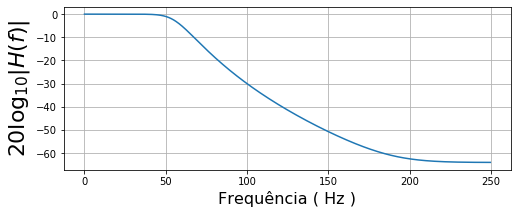

In [7]:
from __future__ import  division
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
import scipy as scp

fs = 500

b1 = [0.2871, -0.4466]
b2 = [-2.1428, 1.1444]
b3 = [1.8566, -0.6303]


a1 = [1, -1.2971, 0.6949]
a2 = [1, -1.069, 0.3699]
a3 = [1, -0.9972, 0.2570]

b = np.convolve(np.convolve(b1,a2),a3) + np.convolve(np.convolve(b2,a1),a3) + np.convolve(np.convolve(b3,a1),a2)

a = np.convolve(np.convolve(a1,a2),a3)


w,H = signal.freqz(b,a) # resposta em frequência

fig,ax = plt.subplots()
fig.set_size_inches((8,3))

ax.plot(w/np.pi*fs/2.,20*np.log10(abs(H)))
ax.set_xlabel("Frequência ( Hz )",fontsize=16)
ax.set_ylabel(r"$20\log_{10} |H(f)| $",fontsize=22)
ymin,ymax = -80,5

ax.grid()

### Método da Trasnformação Bilinear

É um método não linear que se baseia na compressão de todo o eixo $j\Omega$ de plano $s$ no círculo unitário, se sobreposição. Tem a vanteagem de evitar o aliasin e manter a magnitude da resposta em frequência do filtro analógico.

É realizada mapeando $s = \frac{2}{t_d}\left(\frac{1-z^{-1}}{1+z^{-1}}\right)$, ou seja 
$$H(z) = H_c\left[\frac{2}{t_d}\left(\frac{1-z^{-1}}{1+z^{-1}}\right)\right]$$ que pode inverter para obter $$z = \frac{1 + (T_d/2)s}{1 - (T_d/2)s}$$ substituindo $s = \sigma + j\Omega$  obtemos
$$z = \frac{1+\sigma T_d/2 + j\Omega T_d/2}{1-\sigma T_d/2 - j\Omega T_d/2} $$

Pólos no lado esquerdo do plano $s$, são mapeados em pólos dentro do círculo unitário: filtros causais estáveis são mapeados em filtros causais estáveis.

Quando $s = j\Omega,$ $$z = \frac{1+j\Omega T_d/2}{1- j\Omega T_d/2},$$ $|z| = 1$ para todo $s$ no eixo $j\Omega,$ logo podemos escrever $$e^{j\omega} = \frac{1+\sigma T_d/2 + j\Omega T_d/2}{1-\sigma T_d/2 - j\Omega T_d/2},$$ e de $s = \frac{2}{T_d}\left(\frac{1-z^{-1}}{1+z^{-1}}\right)$ obtemos $$s = \frac{2}{T_d}\left(\frac{1-e^{-j\omega}}{1+ze^{-j\omega}}\right)$$

Fazendo $$s = \sigma + j\omega = \frac{2}{T_d}\left[\frac{2e^{-j\omega/2}(j\sin(\omega/2)}{2e^{-j\omega/2}\cos(\omega/2)} \right] = \frac{2j}{T_d}\tan(\omega/2)$$
chegamos a $$\Omega = \frac{2}{T_d}\tan(\omega_2)$$ ou $$\omega = 2 arctg(\Omega T_2/2)$$
